# DenseNet Tests on Imagery

In [1]:
import os
import re
import zipfile
import urllib.request
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models



# Data Loader

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

image_dir = "C:/MSDS/DS6050/Project/Metastasis_Project_Materials/Metastasis_Project_Materials/Images/Sorted Images/224/All"
csv_path = "C:/MSDS/DS6050/Project/Metastasis_Project_Materials/Metastasis_Project_Materials/CSV Files/final_data.csv"

batch_size = 32
img_height = 224
img_width = 224
num_classes = 2
class_names = ['0','1']

Using device: cpu


In [3]:
unmatched_labels = []
class MetastasisDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        df = pd.read_csv(csv_path)

        # Normalize codes (remove dashes/underscores)
        df['Code'] = df['Code'].astype(str).str.replace(r'[-_]', '', regex=True)
        self.label_map = dict(zip(df['Code'], df['Metastasis'].astype(str)))

        self.image_paths = []
        self.labels = []
        self.patient_ids = []
        unmatched_images = 0

        for fname in os.listdir(image_dir):
            # Normalize filename (remove dashes/underscores)
            fname_norm = fname.replace("-", "").replace("_", "")
            matched = False
            for pid in self.label_map:
                pid_norm = pid.replace("-", "").replace("_", "")
                if pid_norm in fname_norm:
                    self.image_paths.append(os.path.join(image_dir, fname))
                    self.labels.append(int(self.label_map[pid]))
                    self.patient_ids.append(pid)
                    matched = True
                    break
            if not matched:
                unmatched_images += 1
                unmatched_labels.append(fname)
               # print(f"Unmatched file: {fname}")
        print(f"Number of images that were not matched = {unmatched_images}")
        print(f"Loaded {len(self.image_paths)} labeled images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        patient_id = self.patient_ids[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, patient_id


# Transforms & Data Loader

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=val_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_paths, val_paths, train_labels, val_labels, train_ids, val_ids = train_test_split(
    full_dataset.image_paths,
    full_dataset.labels,
    full_dataset.patient_ids,
    test_size=0.2,
    stratify=full_dataset.labels,
    random_state=42
)

# Patient ID workaround begin code:

df = pd.DataFrame({
    "image_path": full_dataset.image_paths,
    "label": full_dataset.labels,
    "patient_id": full_dataset.patient_ids
})

patient_labels = df.groupby("patient_id")["label"].max().reset_index()

train_patients, val_patients = train_test_split(
    patient_labels["patient_id"],
    test_size=0.2,
    stratify=patient_labels["label"],  # stratify by patient-level label
    random_state=42
)

train_df = df[df["patient_id"].isin(train_patients)]
val_df   = df[df["patient_id"].isin(val_patients)]

# Sanity check
print("Train patients:", train_df["patient_id"].nunique())
print("Val patients:", val_df["patient_id"].nunique())
print("Overlap:", set(train_df["patient_id"]) & set(val_df["patient_id"]))  # should be empty
print("Train label counts:\n", train_df["label"].value_counts())
print("Val label counts:\n", val_df["label"].value_counts())

### Old code

'''
# Wrap back into Dataset objects
train_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=train_transform)
train_dataset.image_paths, train_dataset.labels, train_dataset.patient_ids = train_paths, train_labels, train_ids

val_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=val_transform)
val_dataset.image_paths, val_dataset.labels, val_dataset.patient_ids = val_paths, val_labels, val_ids
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}, Val dataset size: {len(val_dataset)}")
'''

# New Code
train_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=train_transform)
train_dataset.image_paths  = train_df["image_path"].tolist()
train_dataset.labels       = train_df["label"].tolist()
train_dataset.patient_ids  = train_df["patient_id"].tolist()

val_dataset = MetastasisDataset(image_dir=image_dir, csv_path=csv_path, transform=val_transform)
val_dataset.image_paths    = val_df["image_path"].tolist()
val_dataset.labels         = val_df["label"].tolist()
val_dataset.patient_ids    = val_df["patient_id"].tolist()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Number of images that were not matched = 426
Loaded 946 labeled images.
Train patients: 104
Val patients: 27
Overlap: set()
Train label counts:
 label
0    481
1    307
Name: count, dtype: int64
Val label counts:
 label
0    100
1     58
Name: count, dtype: int64
Number of images that were not matched = 426
Loaded 946 labeled images.
Number of images that were not matched = 426
Loaded 946 labeled images.


### Note to add EL-0 to final CSV file as there are no EL-0xxxxx patients represented. Data on these patients in Onkos_Todo.csv in "Raw_CSV" folder

# Block for checking class imbalance

In [5]:
counts = collections.Counter(full_dataset.labels)
train_counts = collections.Counter(train_dataset.labels)
val_counts = collections.Counter(val_dataset.labels)

print(f'Metastasis Count in Full Dataset: {counts[1]}')
print(f'Non-Metastatic Count in Full Dataset: {counts[0]}')
print(f'Class imbalance in the Full dataset is: {counts[1] / (counts[0]+counts[1])} for Metastasis Representation')
print()
print(f'Class Imbalance Count in Train Dataset: {train_counts[1] / (train_counts[0]+train_counts[1])}')
print(f'Class Imbalance Count in Validation Dataset: {val_counts[1] / (val_counts[0]+val_counts[1])}')
print()
if abs((train_counts[1] / (train_counts[0]+train_counts[1])) - val_counts[1] / (val_counts[0]+val_counts[1])) < 0.03:
    print("Training and Test sets are balanced")
else:    
    print("Training and Test sets are not balanced")

Metastasis Count in Full Dataset: 365
Non-Metastatic Count in Full Dataset: 581
Class imbalance in the Full dataset is: 0.3858350951374207 for Metastasis Representation

Class Imbalance Count in Train Dataset: 0.3895939086294416
Class Imbalance Count in Validation Dataset: 0.3670886075949367

Training and Test sets are balanced


# Getting Pretrained Layers and adding new layers

### DenseNet Variant Selector Function

In [6]:
# Use this to test the various densenets layers 
#model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

def densenet_option(num=121):
    match num:
        case 121:
            return models.densenet121(weights=models.DenseNet121_Weights.DEFAULT), "DenseNet121"
        case 169:
            return models.densenet169(weights=models.DenseNet169_Weights.DEFAULT), "DenseNet169"
        case 201:
            return models.densenet201(weights=models.DenseNet201_Weights.DEFAULT), "DenseNet201"
        case 264:
            return models.densenet264(weights=models.DenseNet264_Weights.DEFAULT), "DenseNet264"


### Ablation/Tuning Selector Function

In [7]:
def freeze_all_except(model, train_blocks=None, train_classifier=True):
    """
    train_blocks: list of block indices you want to train, e.g. [4] or [3,4]
    train_classifier: True/False — whether classifier is trainable
    """
    # First freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Train classifier (optional)
    if train_classifier:
        for param in model.classifier.parameters():
            param.requires_grad = True

    # Train selected DenseNet blocks
    if train_blocks is not None:
        for block_num in train_blocks:
            block_name = f"denseblock{block_num}"
            block = getattr(model.features, block_name, None)
            if block is not None:
                for param in block.parameters():
                    param.requires_grad = True
            else:
                print(f"[Warning] {block_name} not found in model")




### Implement Model Tuning

In [8]:
# Load model
# Select the DenseNet Variant select from [121, 169, 201, 264]
# model, densenet_name = densenet_option(169) - example
model, densenet_name = densenet_option(201)

# Replace classifier - customizes the classifier
# returns pretrained features to be used as input into classifier
# to remap
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# ======== APPLY DENSENET ABLATION HERE =========
# OPTIONS:
#freeze_all_except(model, train_blocks=[], train_classifier=True)   # Only classifier
#freeze_all_except(model, train_blocks=[4])        # Train only DenseBlock4 + classifier
#freeze_all_except(model, train_blocks=[3,4])   # Train DenseBlock3 + DenseBlock4 + classifier
#freeze_all_except(model, train_blocks=[2,3,4]) # Train last DenseBlock2 + DenseBlock3 +DenseBlock4 + classifier
freeze_all_except(model, train_blocks=[1,2,3,4]) # Train last DenseBlock2 + DenseBlock3 +DenseBlock4 + classifier

# ===============================================

# Move model to device, device set in Data Loader - CPU or GPU
model.to(device)
print(f"{densenet_name} Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


DenseNet201 Parameters: 16,797,250


#### Verify Model Architecture

In [9]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## DenseNet - Original Code for ref

# Training Utility Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels, _ in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return epoch_loss, epoch_acc, cm, report


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, cm, report = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print("\nConfusion Matrix:\n", cm)
        scheduler.step()

    return history


def plot_training_history(history, title="Training History", second_title="Full Fine-Tuning"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss\nTrained Params: {second_title}')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy\nTrained Params: {second_title}')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{second_title}.png", dpi=300, bbox_inches='tight') # 300 dpi for IEEE
    plt.show()

# Executive Block

Testing Pretrained DenseNet201 on 224x224 Metastasis Images

Epoch 1/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Train Loss: 0.5478, Train Acc: 71.95%
Val Loss: 0.5275, Val Acc: 84.81%

Confusion Matrix:
 [[92  8]
 [16 42]]

Epoch 2/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Train Loss: 0.2215, Train Acc: 93.78%
Val Loss: 0.4752, Val Acc: 81.65%

Confusion Matrix:
 [[83 17]
 [12 46]]

Epoch 3/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Train Loss: 0.0853, Train Acc: 97.46%
Val Loss: 0.5563, Val Acc: 80.38%

Confusion Matrix:
 [[82 18]
 [13 45]]

Epoch 4/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Train Loss: 0.0492, Train Acc: 98.60%
Val Loss: 0.6929, Val Acc: 77.85%

Confusion Matrix:
 [[74 26]
 [ 9 49]]

Epoch 5/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Train Loss: 0.0247, Train Acc: 99.49%
Val Loss: 0.5275, Val Acc: 81.01%

Confusion Matrix:
 [[84 16]
 [14 44]]

Epoch 6/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Train Loss: 0.0252, Train Acc: 99.24%
Val Loss: 0.5302, Val Acc: 82.91%

Confusion Matrix:
 [[88 12]
 [15 43]]

Epoch 7/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Train Loss: 0.0106, Train Acc: 99.87%
Val Loss: 0.5192, Val Acc: 81.65%

Confusion Matrix:
 [[87 13]
 [16 42]]

Epoch 8/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Train Loss: 0.0072, Train Acc: 100.00%
Val Loss: 0.5386, Val Acc: 82.28%

Confusion Matrix:
 [[87 13]
 [15 43]]

Epoch 9/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Train Loss: 0.0063, Train Acc: 100.00%
Val Loss: 0.5518, Val Acc: 82.28%

Confusion Matrix:
 [[85 15]
 [13 45]]

Epoch 10/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Train Loss: 0.0053, Train Acc: 100.00%
Val Loss: 0.5758, Val Acc: 82.28%

Confusion Matrix:
 [[87 13]
 [15 43]]

Epoch 11/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Train Loss: 0.0101, Train Acc: 99.87%
Val Loss: 0.5807, Val Acc: 80.38%

Confusion Matrix:
 [[83 17]
 [14 44]]

Epoch 12/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Train Loss: 0.0076, Train Acc: 100.00%
Val Loss: 0.5861, Val Acc: 82.28%

Confusion Matrix:
 [[87 13]
 [15 43]]

Epoch 13/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Train Loss: 0.0051, Train Acc: 100.00%
Val Loss: 0.5688, Val Acc: 82.28%

Confusion Matrix:
 [[87 13]
 [15 43]]

Epoch 14/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Train Loss: 0.0063, Train Acc: 100.00%
Val Loss: 0.5812, Val Acc: 82.28%

Confusion Matrix:
 [[87 13]
 [15 43]]

Epoch 15/15
------------------------------


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Train Loss: 0.0065, Train Acc: 100.00%
Val Loss: 0.5701, Val Acc: 82.28%

Confusion Matrix:
 [[85 15]
 [13 45]]


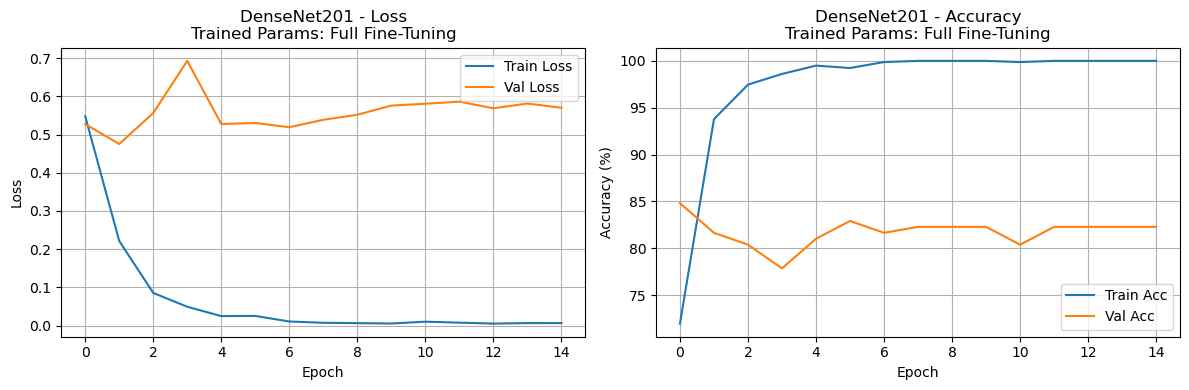

In [11]:
if __name__ == "__main__":
    print("=" * 60)
    #print(f"Testing Pretrained DenseNet121 on {img_height}x{img_width} Metastasis Images")
    print(f"Testing Pretrained {densenet_name} on {img_height}x{img_width} Metastasis Images")
    print("=" * 60)

    test_epochs = 15
    results = {}

    try:
        history = train_model(model, train_loader, val_loader, num_epochs=test_epochs, lr=1e-4)
        #results["DenseNet121"] = history["val_acc"][-1]
        results[densenet_name] = history["val_acc"][-1]
        #plot_training_history(history, "DenseNet121")
        plot_training_history(history, densenet_name)
    except Exception as e:
        #print(f"Error in DenseNet121: {e}")
        print(f"Error in {densenet_name}: {e}")
        results[densenet_name] = 0



# Add Attention to DenseNet

In [12]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

| Experiment | What is trainable          | Purpose                                     |
| ---------- | -------------------------- | ------------------------------------------- |
| **S1**     | Classifier only            | Baseline feature extraction test            |
| **S2**     | DenseBlock4 + classifier   | Ablate contribution of last block           |
| **S3**     | DenseBlock3–4 + classifier | Test depth contribution of final two blocks |
| **S4**     | All blocks                 | Full fine-tuning reference                  |



| Model          | Trainable Layers      | Params Trained | Val Accuracy |
| -------------- | --------------------- | -------------- | ------------ |
| DenseNet201-S1 | classifier only       | 0.5M           | 84.1%        |
| DenseNet201-S2 | block4 + classifier   | 4.7M           | 86.3%        |
| DenseNet201-S3 | block3+4 + classifier | 10.1M          | 87.0%        |
| DenseNet201-S4 | full fine-tune        | 18.3M          | **88.1%**    |
